In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [2]:
DATASET_PATH = "MAFood121\\images\\"
METADATA_PATH = "MAFood121\\metadata_win.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id-red24.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 32
RANDOM_SEED = 115
EPOCHS = 50
TESTING_SIZE = 500
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [3]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-3-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,hunkar_begendi\240.jpg,[hunkar_begendi]
1,hunkar_begendi\21.jpg,[hunkar_begendi]
2,naan\49_1.jpg,[naan]
3,ravioli\2725271.jpg,[ravioli]
4,caprese_salad\2358715.jpg,[caprese_salad]
...,...,...
20670,souvlaki\85_2.jpg,[souvlaki]
20671,breakfast_burrito\805523.jpg,[breakfast_burrito]
20672,nachos\500252.jpg,[nachos]
20673,omelette\800743.jpg,[omelette]


In [4]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [5]:
training_data_generator = ImageDataGenerator(rotation_range=15,
                                             zoom_range=0.1,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.1,
                                             horizontal_flip=False,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 18608 validated image filenames belonging to 121 classes.
Found 2067 validated image filenames belonging to 121 classes.


In [6]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.25))
        model.add(Dropout(.5))
        #model.add(Dense(256))
        #model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        
        model.add(Dense(len(unique_labels), activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=0),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [7]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

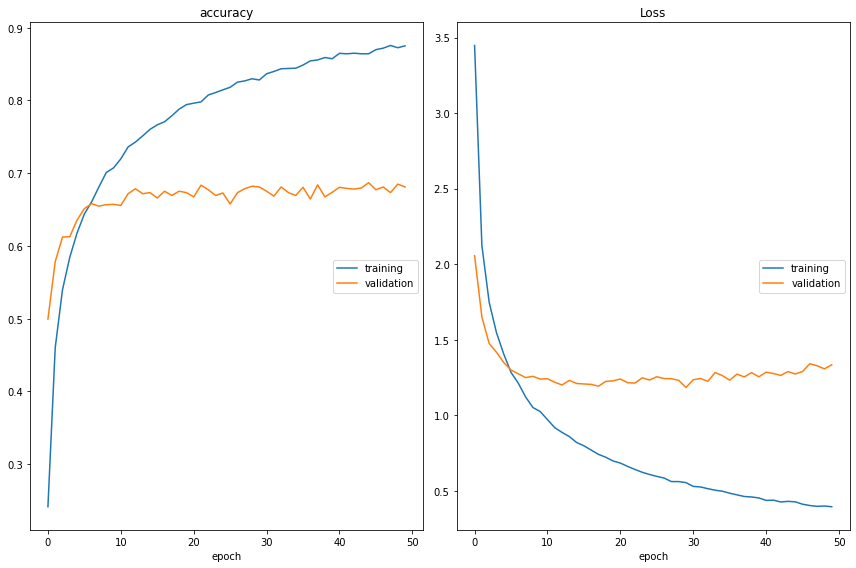

accuracy
	training         	 (min:    0.242, max:    0.876, cur:    0.875)
	validation       	 (min:    0.500, max:    0.687, cur:    0.681)
Loss
	training         	 (min:    0.395, max:    3.448, cur:    0.395)
	validation       	 (min:    1.184, max:    2.057, cur:    1.334)

Epoch 00050: val_accuracy did not improve from 0.68701


In [8]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [9]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 500 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


500/500 [==============================] - 8s 15ms/step


In [10]:
for prediction in predictions:
    print(prediction)

[5.55850147e-06 9.64662991e-03 3.53390787e-05 1.30108219e-06
 4.90516129e-07 1.31869270e-03 2.37541556e-01 1.69321299e-06
 9.14448748e-08 8.04136846e-07 6.87635111e-05 1.04433438e-02
 4.53137227e-06 1.48145235e-04 1.48853974e-03 1.55520938e-05
 3.73247778e-03 6.30049733e-04 1.27988636e-01 4.39594771e-07
 7.13617510e-06 7.88609782e-07 8.83000212e-06 3.25760084e-05
 7.39552979e-06 7.35916998e-08 7.10099266e-05 7.68758309e-06
 2.47464137e-04 1.28864255e-02 5.45217335e-05 4.38692086e-06
 7.54148778e-06 4.40161559e-04 5.96074897e-05 1.91693172e-01
 2.25192844e-06 8.20869502e-07 1.99743006e-02 1.24426167e-02
 3.05673294e-03 3.01967491e-04 1.59032121e-02 4.20836614e-07
 5.28474004e-07 9.78949993e-06 9.35321687e-09 2.76740873e-04
 3.09970062e-07 1.26710734e-06 1.30113426e-06 6.06069761e-06
 2.88220053e-06 8.77188189e-09 3.06124311e-05 1.27802068e-05
 5.25035148e-06 5.49134654e-07 1.95284451e-06 2.94008432e-03
 2.46559521e-05 2.13129952e-05 1.93414890e-04 1.12304951e-05
 3.78534466e-08 4.432371

 2.39089477e-08]
[1.30068585e-07 2.38855700e-05 2.69019347e-06 4.51135094e-07
 2.03258832e-08 1.37147024e-01 9.11331386e-04 9.77013542e-07
 8.21768845e-05 2.43546737e-07 2.77305226e-04 1.96980052e-02
 4.81840516e-07 1.31544031e-04 6.79602963e-04 2.69719112e-06
 1.66812260e-02 4.17133697e-06 1.48529987e-04 7.24676123e-04
 1.99293456e-04 8.80230857e-08 5.09628997e-08 3.82791586e-05
 8.00366990e-08 7.37947194e-05 1.03535058e-04 2.78700008e-06
 1.05372965e-01 2.70506480e-05 1.75863349e-07 6.15965575e-07
 6.11416399e-05 8.26506221e-06 2.66973558e-07 6.50735747e-05
 1.44918010e-06 2.10853963e-04 4.43062949e-04 6.92190835e-04
 8.96404963e-05 3.73839252e-02 6.68404344e-03 1.23865732e-06
 1.00055570e-06 1.11638847e-05 3.20967644e-07 5.31738915e-05
 5.00854338e-03 1.04309489e-04 5.83576970e-04 5.54502719e-08
 2.73917022e-09 1.68153761e-07 5.05087110e-06 4.80219988e-08
 2.77024519e-04 1.08087067e-06 1.58229182e-06 2.12969780e-06
 1.45158352e-04 4.52881359e-05 9.89048509e-04 2.83067457e-05
 1.2809

 9.43985667e-13]
[1.55885598e-08 1.43550096e-06 5.15137065e-12 2.13656381e-08
 1.74451031e-09 1.23020538e-09 1.54157598e-09 1.23421373e-07
 3.96535194e-10 9.70646506e-05 4.38336370e-04 4.16251922e-08
 5.11851360e-11 3.46199123e-08 3.25601945e-08 1.83572688e-12
 3.45760931e-08 4.59070515e-09 1.49387225e-10 3.04681686e-04
 4.12768316e-07 6.49693743e-10 1.47991855e-07 4.88333041e-10
 1.24233317e-08 3.80258911e-07 7.51298357e-10 1.97920876e-04
 6.40699938e-08 1.01170441e-08 3.20355764e-09 1.22398841e-10
 1.11703343e-06 2.03267394e-08 2.18273963e-05 8.28898123e-08
 1.20294455e-04 2.91158540e-06 1.71078227e-08 2.38043572e-06
 2.96437652e-10 1.06447589e-08 8.63342020e-09 2.58632116e-09
 1.66045666e-09 9.93797222e-09 1.58440061e-09 4.95497687e-09
 3.24522239e-06 7.71657651e-12 2.69488783e-06 4.94113861e-10
 1.98868761e-08 3.42989282e-04 3.86516462e-07 1.41543195e-08
 5.89100546e-10 3.09366821e-09 1.36801589e-07 1.52919358e-10
 9.84081507e-01 2.72716534e-07 3.24042237e-10 6.55793642e-08
 4.3047

 2.50414161e-08]
[4.76539386e-09 3.84314888e-04 2.83847726e-06 8.02208319e-07
 1.22169859e-03 1.13713547e-07 2.02048142e-02 6.68106622e-07
 3.32717354e-06 3.22297140e-08 1.50517095e-04 1.68805443e-07
 1.37942901e-03 8.92673135e-02 7.61435572e-08 1.52333465e-03
 3.96622681e-07 2.73456244e-04 4.45953992e-05 1.16852482e-06
 4.13807975e-05 2.25351541e-05 5.74589416e-04 6.07937924e-04
 1.19978713e-05 7.46704188e-07 4.58781585e-07 2.13889143e-06
 3.20536788e-06 5.83739281e-01 8.13083781e-04 1.42103927e-02
 1.80657971e-05 9.16054069e-06 5.12770843e-04 8.56021827e-04
 2.19109477e-08 6.23496499e-06 7.71077573e-02 1.82587928e-06
 1.04177649e-04 8.21119672e-10 3.72898421e-06 4.76311346e-09
 2.52982971e-07 9.72032922e-07 7.92677355e-08 3.84993518e-06
 1.10303063e-07 2.21561160e-04 3.51303286e-04 7.15054703e-05
 1.46340153e-06 6.59205746e-10 4.25047801e-06 4.61865085e-07
 2.11049501e-05 4.66914472e-08 5.80663527e-06 3.08338786e-05
 1.20771097e-06 2.17114712e-06 2.16806620e-06 2.59162451e-04
 4.6259

 1.50179175e-11]
[5.28426153e-13 9.99105752e-01 1.37951651e-12 8.19088269e-11
 5.28288169e-09 1.22905608e-09 2.83815149e-09 2.50007908e-08
 5.07915550e-11 6.90860980e-10 1.19658779e-07 6.48614318e-09
 4.50489566e-08 2.16439737e-08 2.36874778e-12 6.14568119e-12
 1.07269834e-07 4.22331947e-09 1.46416665e-08 2.37575537e-09
 4.65626115e-09 4.40346110e-12 1.44202588e-07 1.57269742e-09
 7.49457371e-11 2.68135825e-09 3.74948147e-14 3.53766505e-09
 2.39658415e-11 4.25835989e-09 1.27353941e-08 3.53716809e-04
 2.32144922e-15 5.39660446e-15 1.51718114e-05 1.22880778e-07
 4.15400436e-10 1.54007695e-09 6.74083140e-07 8.26783798e-06
 5.31681578e-13 2.48252217e-11 8.16971707e-13 2.54421640e-11
 7.39370856e-11 3.72854358e-10 3.15249993e-10 5.11465093e-10
 9.46391437e-11 3.43875275e-12 1.38026405e-06 7.87440599e-11
 3.97475830e-09 4.28712343e-11 3.67471375e-06 9.78917228e-07
 8.45585808e-14 3.50026508e-10 1.04882758e-06 2.74180660e-08
 1.80596771e-06 3.99835616e-11 3.22454752e-09 1.26238922e-06
 4.4332

 9.99125659e-01]
[8.92046593e-12 1.30466260e-09 9.99786198e-01 1.85417235e-07
 3.28319927e-10 1.31756139e-09 6.50076659e-10 7.78519305e-10
 2.74812049e-08 2.18349557e-12 1.26152006e-10 4.96152310e-08
 1.01844382e-08 5.01855233e-08 7.02025860e-09 6.27724546e-07
 1.78421342e-05 3.90807108e-05 5.69266589e-09 1.52020281e-08
 4.26976840e-06 3.87274968e-09 1.16241732e-10 7.29870635e-08
 1.05600187e-13 2.13551413e-10 6.26444148e-07 1.47116978e-07
 9.68222125e-09 1.11542909e-06 2.46708574e-08 1.49783368e-08
 1.85460379e-07 5.60445967e-10 1.66760321e-06 7.77476572e-09
 4.66499018e-13 6.65540279e-12 1.18818300e-09 1.04684221e-11
 1.77622628e-08 2.92023998e-07 1.25342421e-08 4.30985837e-11
 9.25974600e-05 7.97380579e-08 5.70184247e-11 1.52565564e-11
 1.92203133e-12 9.51291881e-08 1.29841660e-09 9.57532461e-15
 2.42183877e-11 4.86369706e-14 2.52142973e-10 1.92209942e-10
 1.97726294e-10 2.76050901e-11 4.54173643e-11 5.81456723e-11
 1.18423202e-10 8.35511673e-13 5.56882526e-07 4.35783898e-09
 1.3194

 1.36334626e-02]
[1.72254278e-09 3.02745472e-03 1.05002061e-06 1.15234434e-05
 1.92239690e-06 1.61387868e-06 1.29992681e-04 6.97692758e-06
 1.12871177e-07 6.79362300e-09 6.65551110e-04 5.39287430e-06
 1.23337145e-07 3.96244559e-06 3.06144153e-04 9.23738480e-06
 8.55688268e-06 6.43383146e-06 4.13420184e-06 1.29888227e-04
 2.68875517e-08 2.88251357e-07 2.15858618e-05 9.88142233e-07
 1.63697038e-08 2.74319493e-04 9.38508128e-06 2.80171563e-03
 4.87501620e-06 1.26629137e-04 7.43938799e-05 5.46355404e-05
 7.08507869e-05 3.24001048e-05 5.70009888e-07 1.34059070e-02
 3.32313823e-04 1.55092744e-06 8.53074766e-07 3.28752474e-04
 4.40702524e-06 6.13105385e-06 1.93457221e-04 8.00056034e-04
 4.95371353e-08 8.15722797e-06 7.33284544e-10 4.45085035e-08
 1.17623722e-05 1.38800814e-07 1.79508347e-02 3.80262364e-08
 1.46578198e-08 2.38073330e-08 1.91289291e-04 9.76122010e-08
 5.30122088e-06 1.41222223e-09 4.56405616e-07 7.27495944e-07
 3.23108688e-05 1.07492131e-04 2.72527274e-07 2.87758357e-05
 1.6630

 7.06155566e-13]
[1.12429922e-12 2.55548912e-07 4.84722549e-12 8.67900959e-11
 4.76966966e-10 1.96430042e-11 9.27474897e-09 4.76285834e-07
 1.17281380e-12 3.48857124e-11 7.00790848e-09 9.49358481e-10
 7.36535188e-09 7.67615305e-10 2.51744070e-10 1.67197403e-08
 2.16464222e-10 3.06598844e-12 4.83290241e-10 7.56714080e-10
 9.98525485e-10 1.13320854e-11 4.72193007e-10 2.50778557e-03
 2.00837680e-10 1.26198554e-08 4.17256487e-08 2.24849028e-10
 3.51063688e-12 3.85465704e-09 9.80580395e-10 1.04258421e-10
 4.57353000e-09 3.86766064e-10 1.56807811e-09 3.78114651e-09
 8.15081989e-07 1.15615794e-05 4.78381201e-09 1.28227953e-08
 1.49069229e-10 6.49890142e-11 9.11621889e-09 9.09169984e-09
 1.37238007e-12 7.01276548e-08 1.49000083e-11 1.58301872e-10
 2.49510954e-08 7.81289344e-09 1.47377355e-08 6.50160091e-12
 2.37925304e-11 2.91380852e-12 5.43957546e-10 1.01272622e-10
 9.38713056e-05 2.52968913e-11 5.93504065e-11 6.16971896e-09
 5.94169602e-09 2.45772208e-10 1.42798581e-05 9.40301916e-12
 9.8543

 3.37610473e-08]
[1.48666475e-08 1.04940758e-04 5.37736923e-07 2.87773204e-04
 1.68998033e-01 7.08959647e-09 2.81408709e-02 2.96684112e-02
 4.90364846e-06 3.73505401e-07 5.55289880e-05 5.57980741e-07
 1.35560439e-03 4.16610669e-03 8.71507102e-04 8.00746493e-03
 7.22437505e-07 7.25752581e-03 1.44596115e-05 8.48215495e-06
 3.59967232e-01 1.16040290e-07 1.86396763e-03 5.81966862e-02
 3.29496688e-05 3.50294584e-08 2.26485445e-05 5.61868364e-06
 8.23327753e-08 4.57168383e-08 2.23292052e-04 3.43061634e-03
 6.04291870e-07 3.88256538e-08 1.26109019e-01 1.24403402e-06
 9.42985423e-08 2.85939308e-07 2.46830314e-05 1.03033960e-06
 4.76164685e-04 3.08339077e-04 4.80573590e-08 3.51696981e-05
 7.92801031e-04 4.61360378e-06 5.12551982e-04 5.66085362e-07
 2.62184699e-06 4.19772441e-05 5.11832259e-05 3.32628645e-07
 2.13862018e-06 6.32902086e-08 6.85733321e-05 8.18555236e-06
 1.21239779e-07 1.21371841e-06 1.67252426e-06 8.00429189e-05
 3.09906977e-06 3.74447460e-08 1.63406410e-04 2.94691254e-05
 5.1251

 3.43564456e-12]
[2.1857041e-07 6.4019776e-05 1.0805068e-07 4.2475381e-08 7.9398479e-09
 5.9339147e-02 3.8603821e-06 1.7493630e-06 1.3376969e-05 4.1238181e-08
 2.6882110e-05 6.1854121e-04 3.1154229e-08 2.8427100e-06 1.4575156e-04
 6.6126191e-08 2.0384314e-04 1.3703175e-06 9.3304072e-07 7.0786096e-05
 1.3029598e-05 4.3428929e-05 2.0505648e-07 1.4191241e-07 1.2220875e-08
 3.4641224e-04 1.6042843e-05 2.1149728e-05 8.4760477e-04 1.9400801e-04
 2.3470056e-05 3.6356923e-07 2.8062323e-03 2.2392510e-03 1.4361372e-07
 2.0216785e-01 2.2596390e-05 6.2190466e-08 7.2430737e-09 8.7927438e-05
 2.8335669e-06 3.0850337e-05 1.7315345e-03 2.5354154e-04 3.0144293e-10
 3.8942380e-06 2.7109859e-10 1.5187726e-05 1.0897361e-06 2.8648186e-05
 1.7155979e-03 2.3253998e-08 1.8279702e-07 1.3023803e-06 1.0449592e-04
 4.5622048e-08 2.5632468e-03 3.4971563e-08 7.5447755e-09 2.9467704e-09
 1.4799282e-04 1.4862697e-02 1.9309477e-05 3.7248404e-04 1.0382390e-08
 2.1353309e-05 7.9434109e-08 3.2571123e-05 6.2059735e-09 5.2